In [1]:
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
matplotlib.rcParams['font.size'] = 9

def imshow(img):
    plt.axis("off")
    plt.imshow(img, cmap = 'gray')
    plt.show()

In [3]:
from skimage.transform import resize

def resize_img(img, width = None, height = None):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (w, h) = img.shape[:2]    

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return img

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        output_shape = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        output_shape = (width, int(h * r))

    # resize the image
    resized_img = resize(img, output_shape)

    # return the resized image
    return resized_img

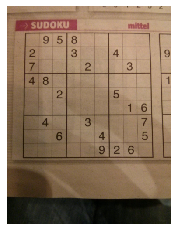

In [4]:
from skimage import io

img = io.imread('dataset/image1006.jpg')
img = resize_img(img, width=500)
imshow(img)

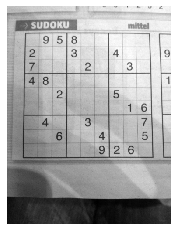

In [5]:
from skimage.color import rgb2gray
gray = rgb2gray(img)
imshow(gray)

In [ ]:
#todo: ADD BLUR
# On rejette les photos floues => use case inutile surout avec les caméras actuelles
# Néamoins : OK :
#    - bruitées : (grain, basse lumière)
#    - ombres (courant photo en intérieur sous une lumière)

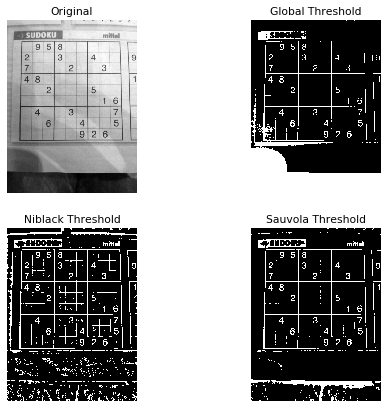

In [6]:
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)

image = gray
binary_global = image < threshold_otsu(image)

window_size = 25
thresh_niblack = threshold_niblack(image, window_size=window_size, k=0.8)
thresh_sauvola = threshold_sauvola(image, window_size=window_size)

binary_niblack = image < thresh_niblack
binary_sauvola = image < thresh_sauvola

plt.figure(figsize=(8, 7))
plt.subplot(2, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Global Threshold')
plt.imshow(binary_global, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(binary_niblack, cmap=plt.cm.gray)
plt.title('Niblack Threshold')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(binary_sauvola, cmap=plt.cm.gray)
plt.title('Sauvola Threshold')
plt.axis('off')

plt.show()

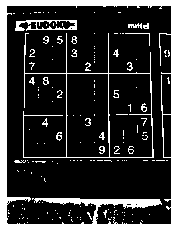

In [183]:
imshow(binary_sauvola)

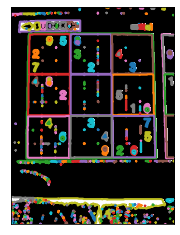

In [7]:
from skimage import measure

contours = measure.find_contours(binary_sauvola, 0.5) # pas de possibilité de garder que les contours intérieurs :/
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(binary_sauvola, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [8]:
import numpy as np

def contour_area(c): # // pas de fonction cv2.ContourArea
    ll, ur = np.min(c, 0), np.max(c, 0)
    wh = ur - ll
    return (wh[0] * wh[1])    

In [9]:
contours.sort(key=lambda c: contour_area(c), reverse=True)
biggest_contour = contours[0]

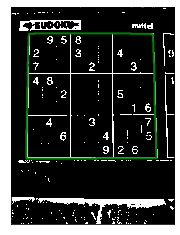

In [10]:
fig, ax = plt.subplots()
ax.imshow(binary_sauvola, cmap=plt.cm.gray)
ax.plot(biggest_contour[:, 1], biggest_contour[:, 0], linewidth=2, color='green')
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

array([168. , 167. , 166.5, ..., 169. , 168.5, 168. ])

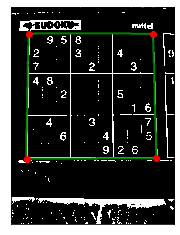

In [11]:
top_left = sorted(biggest_contour, key=lambda p: p[0] + p[1])[0]
top_right = sorted(biggest_contour, key=lambda p: p[0] - p[1])[0]
bottom_left = sorted(biggest_contour, key=lambda p: p[0] - p[1], reverse=True)[0]
bottom_right = sorted(biggest_contour, key=lambda p: p[0] + p[1], reverse=True)[0]

corners = np.array([
        [top_left[1], top_left[0]],
        [top_right[1], top_right[0]],
        [bottom_left[1], bottom_left[0]],
        [bottom_right[1], bottom_right[0]],
    ])


fig, ax = plt.subplots()
ax.imshow(binary_sauvola, cmap=plt.cm.gray)
ax.plot(biggest_contour[:, 1], biggest_contour[:, 0], linewidth=2, color='green')
ax.plot(corners[:, 0], corners[:, 1], color='red', marker='o', 
        linestyle='None', markersize=6)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [12]:
from skimage import transform
L = round(np.linalg.norm(corners[0]-corners[1]))

src =  np.array([[0, 0], [L, 0], [0, L], [L, L]])
dst = corners

In [129]:
L

426.0

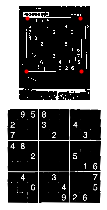

In [13]:
tform3 = transform.ProjectiveTransform()
tform3.estimate(src, dst)
warped = transform.warp(binary_sauvola, tform3, output_shape=(L, L))

fig, ax = plt.subplots(nrows=2, figsize=(8, 3))

ax[0].imshow(binary_sauvola, cmap=plt.cm.gray)
ax[0].plot(dst[:, 0], dst[:, 1], '.r')
ax[1].imshow(warped, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

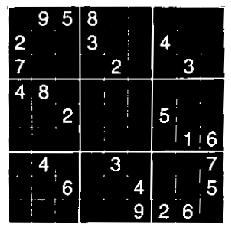

In [14]:
imshow(warped)